# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-05-19 12:41:22.924605


In [3]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [4]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = df.T.rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)
    return df

cases = select_russian_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)
russian_data['cases_a_day'] = russian_data['cases'].diff().fillna(0)

russian_data['is_sick'] = russian_data['cases'] - (russian_data['recovered'] + russian_data['deaths'])
russian_data['lethality'] = russian_data['deaths'] / (russian_data['recovered'] + russian_data['deaths']) 

# Ситуация в Санкт-Петербурге

По данным [официального Штаба](https://t.me/koronavirusspb).

Таблица в гуглдоке поддерживается силами волонтеров.

In [5]:
from io import BytesIO
import requests

In [6]:
google_sheet = 'https://docs.google.com/spreadsheets/d/1gHWu8YStECVLw83aiqNOn6IZfHajZgTSJYOQSrVceSU/export#gid=0&format=csv'
raw_data = requests.get(google_sheet).content
spb_df = pd.read_excel(BytesIO(raw_data), index_col=0)                     

spb_df = spb_df.reset_index()
spb_df['date'] = pd.to_datetime(spb_df['date'], dayfirst=True)

# До этой даты есть легкие отличия в формате
spb_df = spb_df[spb_df['date']> pd.to_datetime('05-04-2020', dayfirst=True)]

holidays = list(spb_df[spb_df['date'].dt.weekday.isin([5,6])]['date'].values)
for date in pd.to_datetime(['01-05-2020', '04-05-2020', '05-05-2020', '11-05-2020'], dayfirst=True):
    holidays.append(date)
    
spb_df['is_workday'] = spb_df['date'].apply(lambda x: 0 if x in holidays else 1)

spb_df = spb_df.reset_index().rename(columns={'index': 'day_number_from_start'}).set_index('date')

spb_df['day_number_from_start'] = spb_df['day_number_from_start'][::-1].values + 1

In [7]:
spb_df['new_death'] = spb_df['all_death'].diff(-1)
spb_df['is_sick'] = spb_df['all_cases'] - (spb_df['all_healthy'] + spb_df['all_death'])

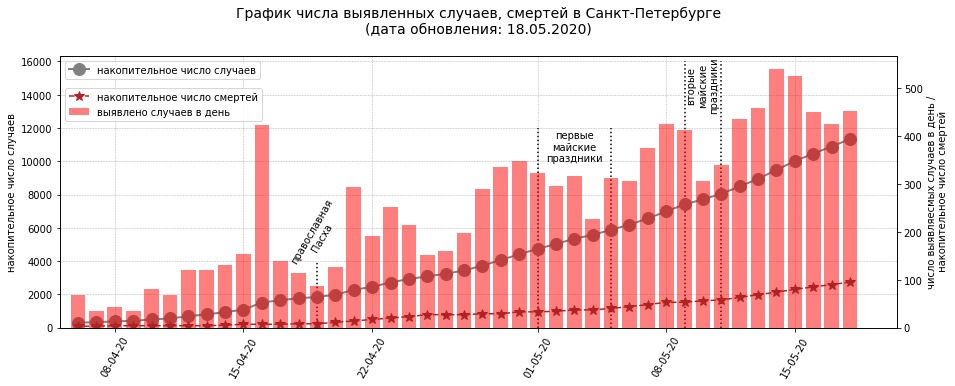

In [8]:
start_date = pd.to_datetime('05-04-2020', dayfirst=True) 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['all_cases'], color='grey', marker='o', 
         linewidth=2, markersize=12, label='накопительное число случаев')

plt.text(pd.to_datetime('19-04-2020', dayfirst=True), 
         3500,
         'православная\nПасха', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=60)
ax1.vlines(pd.to_datetime('19-04-2020', dayfirst=True), 0, 
           4000, 
           linestyle=':')

ax1.vlines(pd.to_datetime('01-05-2020', dayfirst=True), 0, 
           12000, 
           linestyle=':')
plt.text(pd.to_datetime('03-05-2020', dayfirst=True), 
         10000,
         'первые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center')
ax1.vlines(pd.to_datetime('05-05-2020', dayfirst=True), 0, 
           12000, 
           linestyle=':')

ax1.vlines(pd.to_datetime('09-05-2020', dayfirst=True), 0, 
           16000, 
           linestyle=':')
plt.text(pd.to_datetime('10-05-2020', dayfirst=True), 
         13000,
         'вторые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center', rotation=90)
ax1.vlines(pd.to_datetime('11-05-2020', dayfirst=True), 0, 
           16000, 
           linestyle=':')

ax1.set_ylim(0, spb_df['all_cases'].max()+5000)

# ===== вторая ось ========
ax2 = ax1.twinx()
ax2.plot(spb_df.query('all_death > 0')['all_death'], color='firebrick', marker='*', linestyle='--', 
         markersize=10, label='накопительное число смертей')

ax2.bar(x=spb_df.index, 
        height=spb_df[spb_df.index>=pd.to_datetime('03-28-2020')]['new_cases'], 
        color='red', alpha=0.5, label='выявлено случаев в день')

title = '''График числа выявленных случаев, смертей в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#ax1.set_ylim(0, russian_data['cases'].max()+30000)
#ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

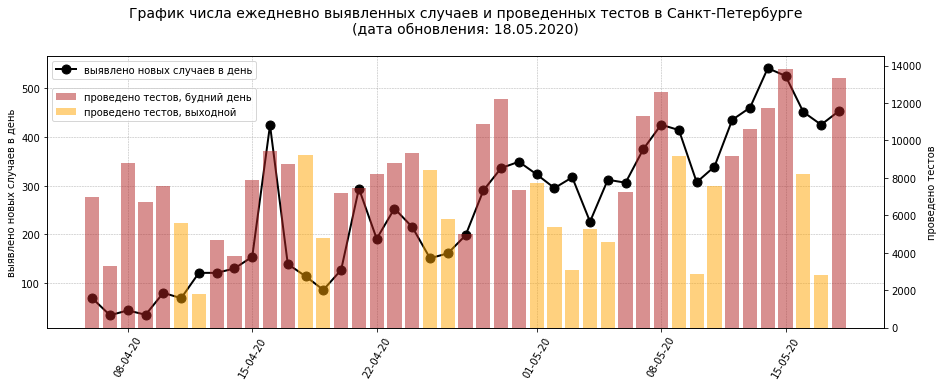

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['new_cases'], color='black', marker='o', 
         linewidth=2, markersize=9, label='выявлено новых случаев в день')

# ===== вторая ось ========
ax2 = ax1.twinx()
ax2.bar(x=spb_df.query('is_workday == 1').index, 
        height=spb_df.query('is_workday == 1')['tested'], 
        color='firebrick', alpha=0.5, label='проведено тестов, будний день')
ax2.bar(x=spb_df.query('is_workday == 0').index, 
        height=spb_df.query('is_workday == 0')['tested'], 
        color='orange', alpha=0.5, label='проведено тестов, выходной')

title = '''График числа ежедневно выявленных случаев и проведенных тестов в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.title(title, fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('выявлено новых случаев в день')
ax2.set_ylabel('проведено тестов')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

In [10]:
spb_df['%_of_new_cases_from_tested'] = spb_df['new_cases'] / spb_df['tested']

In [11]:
spb_df.groupby('is_workday')['%_of_new_cases_from_tested'].mean()

is_workday
0    0.054342
1    0.028613
Name: %_of_new_cases_from_tested, dtype: float64

In [12]:
from scipy.stats import spearmanr

In [13]:
print('=== Корреляция числа выявленных случаев с другими показателями ===\n')

target = 'new_cases'
for column in spb_df.select_dtypes(exclude='object').columns:
    if column not in [target, 'is_workday']:
        sprm = spearmanr(spb_df[column].values, 
                          spb_df[target].values,
                          nan_policy='omit')
        if sprm[1] <= 0.05:
            print(f'{column}: {sprm[0]}, p-value {sprm[1]}')

=== Корреляция числа выявленных случаев с другими показателями ===

day_number_from_start: 0.9027751615400516, p-value 1.293994733289464e-16
all_cases: 0.9027751615400516, p-value 1.293994733289464e-16
all_death: 0.9008562586382466, p-value 1.8959528302739303e-16
all_healthy: 0.9024657333775851, p-value 1.3769400071700304e-16
tested: 0.4776288495809976, p-value 0.0011998414562257864
quarantined_for_now: -0.6338028173532537, p-value 5.055085711338213e-06
quarantined_observation: 0.6725371529520938, p-value 7.829003682754531e-07
new_death: 0.6620289100678577, p-value 1.8000098228387286e-06
is_sick: 0.9039833926219957, p-value 1.0132171911157873e-16
%_of_new_cases_from_tested: 0.7346044978219675, p-value 2.0513076189175916e-08


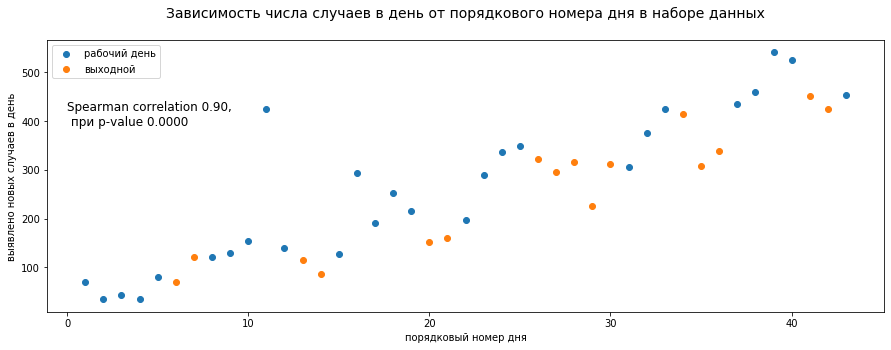

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=spb_df.query('is_workday == 1')['day_number_from_start'],
            y=spb_df.query('is_workday == 1')['new_cases'], label='рабочий день')
plt.scatter(x=spb_df.query('is_workday == 0')['day_number_from_start'],
            y=spb_df.query('is_workday == 0')['new_cases'], label='выходной')


sprm = spearmanr(spb_df['day_number_from_start'].values, 
                 spb_df['new_cases'].values,
                 nan_policy='omit')

plt.xlabel('порядковый номер дня')
plt.ylabel('выявлено новых случаев в день')
plt.title('Зависимость числа случаев в день от порядкового номера дня в наборе данных\n', fontsize=14)
plt.text(0, spb_df['new_cases'].max()-150, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.legend()
plt.show()

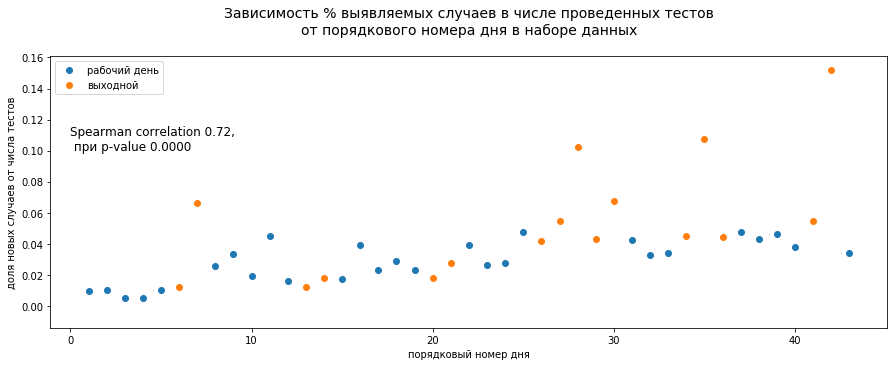

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=spb_df.query('is_workday == 1')['day_number_from_start'],
            y=spb_df.query('is_workday == 1')['%_of_new_cases_from_tested'], label='рабочий день')
plt.scatter(x=spb_df.query('is_workday == 0')['day_number_from_start'],
            y=spb_df.query('is_workday == 0')['%_of_new_cases_from_tested'], label='выходной')

sprm = spearmanr(spb_df['day_number_from_start'].values, 
                 spb_df['%_of_new_cases_from_tested'].values,
                 nan_policy='omit')

plt.xlabel('порядковый номер дня')
plt.ylabel('доля новых случаев от числа тестов')
plt.title('Зависимость % выявляемых случаев в числе проведенных тестов\nот порядкового номера дня в наборе данных\n', fontsize=14)

plt.text(0, 0.1, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.legend()
plt.show()

In [16]:
print('=== Корреляция числа больных и ежедневного числа смертей ===\n')
for i in range(0, 15):
    sprm = spearmanr(spb_df['new_death'].shift(i).values, 
              spb_df['is_sick'].values,
              nan_policy='omit')
    if sprm[1] <= 0.05:
            print(f'Сдвиг числа умерших от covid-19 на {i} дней вперед: {sprm[0]}, p-value {sprm[1]}')

=== Корреляция числа больных и ежедневного числа смертей ===

Сдвиг числа умерших от covid-19 на 0 дней вперед: 0.6903468237273419, p-value 4.2211462070859154e-07
Сдвиг числа умерших от covid-19 на 1 дней вперед: 0.6841718370289468, p-value 5.870826052960989e-07
Сдвиг числа умерших от covid-19 на 2 дней вперед: 0.6762410626163843, p-value 1.2178736991207941e-06
Сдвиг числа умерших от covid-19 на 3 дней вперед: 0.6903969579949698, p-value 8.240363951485042e-07
Сдвиг числа умерших от covid-19 на 4 дней вперед: 0.6782863575035499, p-value 2.086661119211315e-06
Сдвиг числа умерших от covid-19 на 5 дней вперед: 0.6729802102330109, p-value 3.6731759564011254e-06
Сдвиг числа умерших от covid-19 на 6 дней вперед: 0.6492987693643919, p-value 1.375972853719514e-05
Сдвиг числа умерших от covid-19 на 7 дней вперед: 0.6389660171196102, p-value 2.73819779601431e-05
Сдвиг числа умерших от covid-19 на 8 дней вперед: 0.6154229685091223, p-value 8.330757157162465e-05
Сдвиг числа умерших от covid-19 на 9

**Летальность** рассчитывается от числа разрешившихся случаев. Считать ее от «общего числа случаев» неверно с точки зрения сравнения данных (так как не известно, как разрешатся случаи, которые еще «в процессе»).

In [17]:
spb_df['lethality'] = spb_df['all_death'] / (spb_df['all_healthy'] + spb_df['all_death']) 
spb_df['lethality'].describe()

count    43.000000
mean      0.040249
std       0.012327
min       0.023952
25%       0.031269
50%       0.036546
75%       0.046845
max       0.076923
Name: lethality, dtype: float64

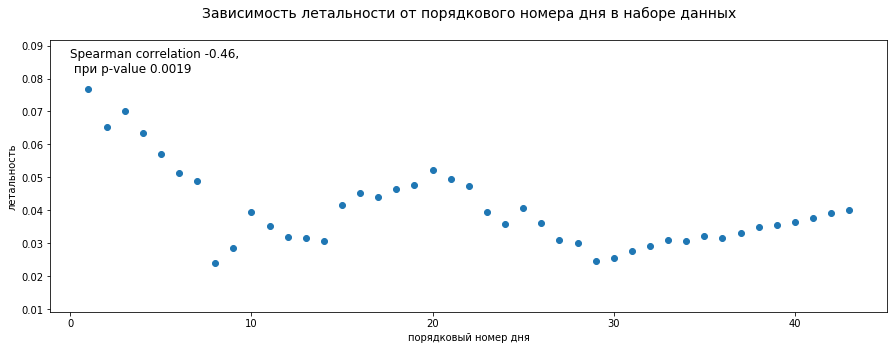

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=spb_df['day_number_from_start'],
            y=spb_df['lethality'])
sprm = spearmanr(spb_df['day_number_from_start'].values, 
                 spb_df['lethality'].values,
                 nan_policy='omit')

plt.xlabel('порядковый номер дня')
plt.ylabel('летальность')
plt.title('Зависимость летальности от порядкового номера дня в наборе данных\n', fontsize=14)

plt.text(0, spb_df['lethality'].max()+0.005, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.show()

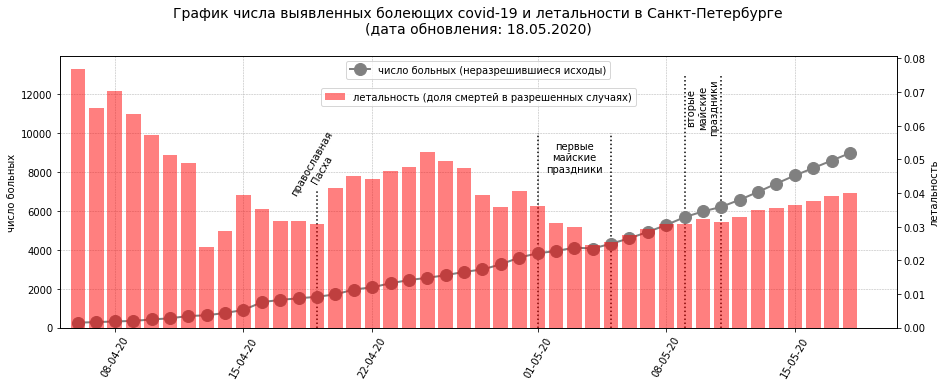

In [19]:
start_date = pd.to_datetime('05-04-2020', dayfirst=True) 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['is_sick'], color='grey', marker='o', 
         linewidth=2, markersize=12, label='число больных (неразрешившиеся исходы)')

plt.text(pd.to_datetime('19-04-2020', dayfirst=True), 
         6500,
         'православная\nПасха', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=60)
ax1.vlines(pd.to_datetime('19-04-2020', dayfirst=True), 0, 
           7000, 
           linestyle=':')

ax1.vlines(pd.to_datetime('01-05-2020', dayfirst=True), 0, 
           10000, 
           linestyle=':')
plt.text(pd.to_datetime('03-05-2020', dayfirst=True), 
         8000,
         'первые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center')
ax1.vlines(pd.to_datetime('05-05-2020', dayfirst=True), 0, 
           10000, 
           linestyle=':')

ax1.vlines(pd.to_datetime('09-05-2020', dayfirst=True), 0, 
           13000, 
           linestyle=':')
plt.text(pd.to_datetime('10-05-2020', dayfirst=True), 
         10000,
         'вторые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center', rotation=90)
ax1.vlines(pd.to_datetime('11-05-2020', dayfirst=True), 0, 
           13000, 
           linestyle=':')

ax1.set_ylim(0, spb_df['is_sick'].max()+5000)

# ===== вторая ось ========
ax2 = ax1.twinx()

ax2.bar(x=spb_df.index, 
        height=spb_df['lethality'], 
        color='red', alpha=0.5, label='летальность (доля смертей в разрешенных случаях)')

title = '''График числа выявленных болеющих covid-19 и летальности в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#ax1.set_ylim(0, russian_data['cases'].max()+30000)
#ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(loc='upper center')
ax2.legend(loc='upper center', bbox_to_anchor=(0.25, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('число больных')
ax2.set_ylabel('летальность')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

# Сравнение со всей Россией

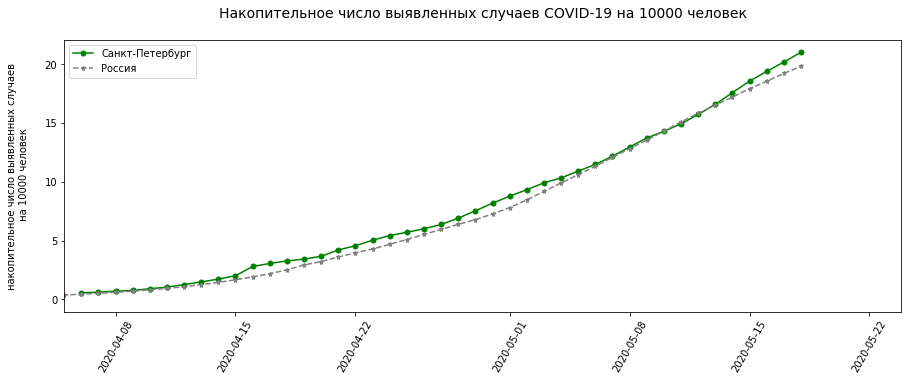

In [20]:
n = 10000

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(spb_df['all_cases'] / 5398064 * n, color='green', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(russian_data['cases'] / 146748590 * n, color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Накопительное число выявленных случаев COVID-19 на {n} человек\n', fontsize=14)
plt.xlim(start_date)
plt.ylabel(f'накопительное число выявленных случаев\n на {n} человек\n')
plt.legend()
plt.show()

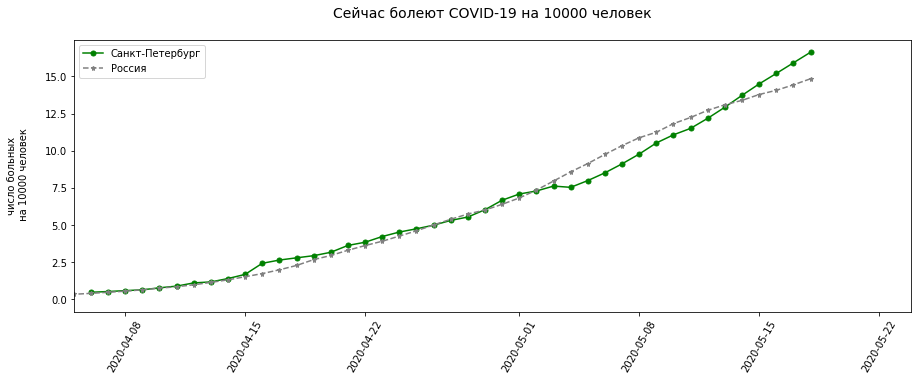

In [21]:
n = 10000

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(spb_df['is_sick'] / 5398064 * n, color='green', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(russian_data['is_sick'] / 146748590 * n, color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Сейчас болеют COVID-19 на {n} человек\n', fontsize=14)
plt.xlim(start_date)
plt.ylabel(f'число больных\n на {n} человек\n')
plt.legend()
plt.show()

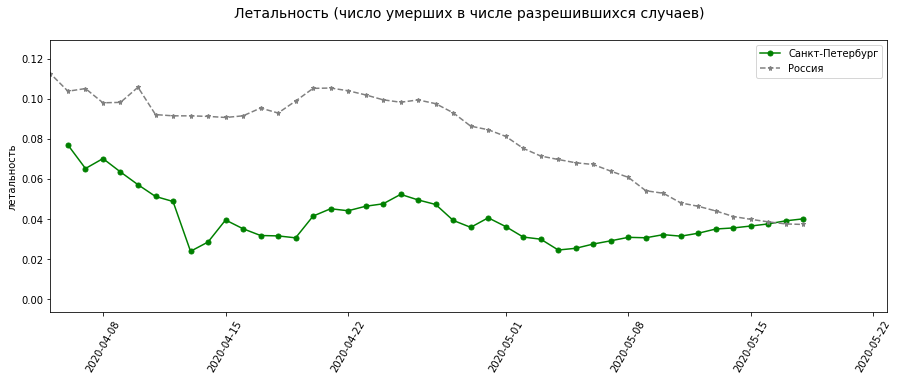

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(spb_df['lethality'], color='green', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(russian_data['lethality'], color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Летальность (число умерших в числе разрешившихся случаев)\n', fontsize=14)
plt.xlim(start_date)
plt.ylabel(f'летальность')
plt.legend()
plt.show()